In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
train_dir = '../../../Data/Augmented_cat_dog/'
validation_dir = '../../../Data/cat_dog/Test/'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def printImage(image):
    # Get one sample from the dataset
    image, label = image
    
    # Convert image tensor to numpy and transpose for matplotlib (C, H, W) → (H, W, C)
    np_image = image.numpy().transpose((1, 2, 0))
    
    # Undo normalization (reverse of Normalize([0.5]*3, [0.5]*3))
    np_image = np_image * 0.5 + 0.5
    
    # Plot
    plt.imshow(np_image)
    plt.title(f"Label: {label} ({list(train_dataset.class_to_idx.keys())[label]})")
    plt.axis('off')
    plt.show()


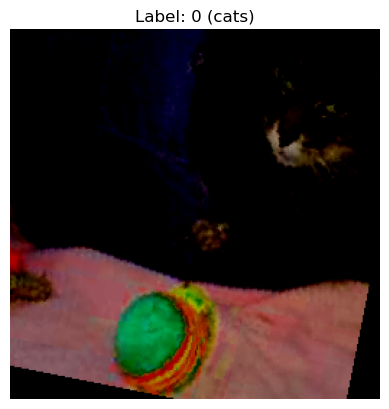

In [5]:
printImage(train_dataset[2560])

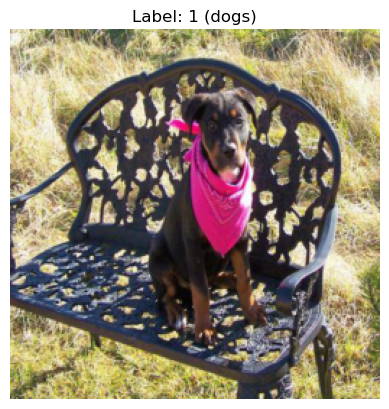

In [6]:
printImage(validation_dataset[1260])

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32,shuffle=True)

In [8]:
class CnnCatDogClassifier(nn.Module):
    def __init__(self,input_features):
        super(CnnCatDogClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(input_features,32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(32,64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(64*64*64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256,2)
        )
    def forward(self,x):
        return self.classifier(self.features(x))
    

In [14]:
epochs = 8 
learning_rate = 0.01

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CnnCatDogClassifier(input_features=3).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [15]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images , labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        y_pred = model(images)
        
        optimizer.zero_grad()
        loss = criterion(y_pred, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        

Epoch 1/8 | Loss: 469.0000 | Train Accuracy: 66.63%
Epoch 2/8 | Loss: 430.9947 | Train Accuracy: 70.79%
Epoch 3/8 | Loss: 380.9731 | Train Accuracy: 75.46%
Epoch 4/8 | Loss: 323.6604 | Train Accuracy: 79.99%
Epoch 5/8 | Loss: 278.1915 | Train Accuracy: 83.30%
Epoch 6/8 | Loss: 232.2657 | Train Accuracy: 86.62%
Epoch 7/8 | Loss: 200.8820 | Train Accuracy: 88.41%
Epoch 8/8 | Loss: 168.4615 | Train Accuracy: 90.56%


In [16]:
model.eval()

val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in validation_dataloader:
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        _, predicted = torch.max(y_pred, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
        
    val_acc = (100 * val_correct) / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

Validation Accuracy: 58.60%



In [18]:
model.eval()

val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        _, predicted = torch.max(y_pred, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
        
    val_acc = (100 * val_correct) / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

Validation Accuracy: 96.19%



In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Optional: Trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 134371202
Trainable parameters: 134371202
